# Klasifikacija žanra filma na osnovu njegovog postera

In [1]:
import pandas as pd
import numpy as np
import urllib
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn import model_selection
from random import sample
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tabulate import tabulate

## Analiza podataka

Učitavamo podatke iz baze "41K movie posters from IMDB" koja se nalazi na [linku](https://www.kaggle.com/datasets/dadajonjurakuziev/movieposter?resource=download). 

In [2]:
data=pd.read_csv('duplicate_free_41K.csv')

In [3]:
data.shape 

(41979, 19)

Naša baza ima 41979 instanci i 19 kolona čija imena su prikazana ispod.

In [4]:
data.columns

Index(['id', 'poster', 'title', 'year', 'rating', 'genre', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'drama', 'fantasy',
       'horror', 'mystery', 'romance', 'sci-fi', 'short', 'thriller'],
      dtype='object')

In [6]:
data.head()

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,short,thriller
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,1,0
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,1,0
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,0


Baza sadrži linkove do postera filma i 13 žanrova koji su već binarno iskodirani.

In [7]:
sum(data['poster'].isna()) #proveravamo da li u podacima imamo Na vrednosti

0

In [8]:
sum(data['genre'].isna())

0

U bazi nema Na vrednosti.

U bazi su dati žanrovi: akcija(action), avantura(adventure), animirani (animation), komedija(comedy), kriminalistički(crime), drama(drama), fantazija(fantasy), horor(horror), misterija(mystery), romantični(romance), naučna fantastika(sci-fi), kratkometražni(short) i triler(thriller).

S obzirom na to da kratkometražni film označava film kraćeg trajanja (a ne film specijalnog žanra), ovu kolonu ćemo izbaciti iz naše baze. Prethodno smo proverili da li postoji neki film kom je dodeljem samo ovaj žanr, ali pošto to nije slučaj, možemo obrisati kolonu iz podataka.

In [10]:
data[data.short==1][data.action==0][data.adventure==0][data.animation==0][data.comedy==0][data.crime==0][data.drama==0][data.fantasy==0][data.horror==0][data.mystery==0][data.romance==0][data.thriller==0][data['sci-fi']==0].index

Int64Index([], dtype='int64')

In [11]:
data=data.drop(columns='short')

In [13]:
broj_zanrova=data.iloc[:,6:18].sum(axis=1).values

In [14]:
data = data.assign(broj_zanrova=broj_zanrova)
#dodajemo kolonu broj žanrova kako bismo videli ima li filmova koji nemaju nijedan žanr i kako bismo bolje ispitali podatke
    

In [15]:
data.head()

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,thriller,broj_zanrova
0,0,https://m.media-amazon.com/images/M/MV5BNDM0ND...,Construction,2021,7.4,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,2
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,0,2
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,0,2
4,4,https://m.media-amazon.com/images/M/MV5BOGI0Nz...,Asalu Em Jarigindhante,2020,10.0,drama,0,0,0,0,0,1,0,0,0,0,0,0,1


In [16]:
data.broj_zanrova.value_counts().sort_values()

1     9430
2    14672
3    17877
Name: broj_zanrova, dtype: int64

Svaki film ima zadat bar jedan žanr i najviše imamo filmova sa tri žanra

<BarContainer object of 3 artists>

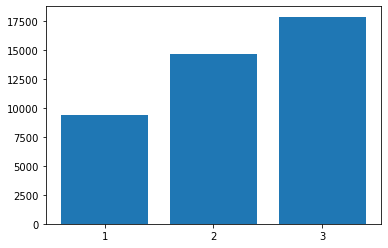

In [17]:
plt.bar(['1','2','3'],data.broj_zanrova.value_counts().sort_values().values)

In [18]:
data.iloc[:,6:18] #vidimo da imamo 12 žanrova i želimo da ispitamo kakva je izbalansiranost među njima


,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,thriller
0,0,0,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
41974,1,1,0,0,0,1,0,0,0,0,0,0
41975,1,1,0,1,0,0,0,0,0,0,0,0
41976,0,0,0,1,0,1,0,0,0,0,0,0
41977,0,0,0,0,0,0,0,1,0,0,0,1


In [19]:
data.iloc[:,6:18].sum(axis=0)
#posmatramo koliko filmova imamo od datih žanrova

action       10537
adventure     5693
animation     5318
comedy       14410
crime         6119
drama        16318
fantasy       3819
horror        7291
mystery       4760
romance       7432
sci-fi        3609
thriller      7099
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

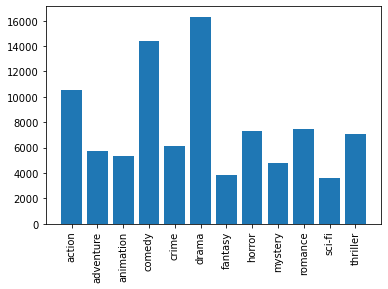

In [20]:
plt.bar(data.iloc[:,6:18].sum(axis=0).index,data.iloc[:,6:18].sum(axis=0).values)
plt.xticks(rotation='vertical')

Na histogramu uočavamo da su drama, komedija i akcija najučestaliji žanrovi i pokušaćemo da bar malo izbalansiramo
podatke kako bi se ova razlika smanjila. S obzirom da film može imati više različitih žanrova ne možemo nasumično smanjiti broj filmova sa vodecim žanrovima jer to može ugroziti i one manje zastupljene. 

Iz tog razloga, pogledaćemo sve kombinacije žanrova koje imamo i redukovati one kojih ima najviše gledajući da se ti žanrovi poklope sa žanrovima koji su iznad istaknuti kao najfrekventniji.

In [21]:
kombinacije_zanrova=pd.get_dummies(data.genre)

In [22]:
kombinacije_zanrova.shape #imamo 377 razlicitih kombinacija 

(41979, 377)

In [23]:
kombinacije_zanrova.sum(axis=0)

action                       453
action, adventure            106
action, adventure, comedy    673
action, adventure, crime     235
action, adventure, drama     433
                            ... 
short, romance, thriller       1
short, sci-fi                207
short, sci-fi, thriller       22
short, thriller               17
thriller                     802
Length: 377, dtype: int64

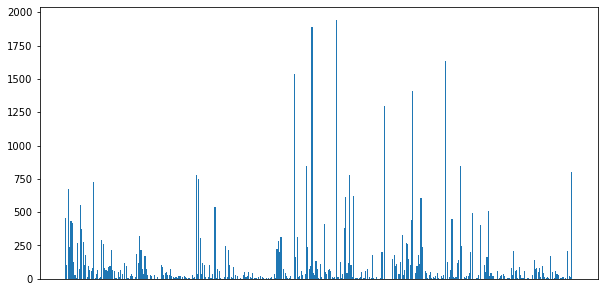

In [24]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_zanrova.sum(axis=0).index,kombinacije_zanrova.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

Na grafiku iznad uočavamo da su neke kombinacije žanrova dosta učestalije pa ćemo sortirati podatke kako bismo videli o kojim
kombinacijama je reč.

In [25]:
kombinacije_zanrova.sum(axis=0).sort_values(ascending=False).head(15)

comedy, romance                 1942
comedy, drama, romance          1886
horror                          1634
comedy                          1533
drama, romance                  1408
drama                           1294
horror, thriller                 847
comedy, drama                    844
thriller                         802
animation                        780
crime, drama, mystery            779
animation, action, adventure     746
action, crime, drama             725
action, adventure, comedy        673
crime, drama, thriller           623
dtype: int64

Vidimo da u vodećim kombinacijama ima dosta pojavljivanja komedije i drame.S obzirom da su ova dva žanra najfrekventnija,
redukovanje kombinacija koje ih sadrže će doprineti da histogram frekvencije pojedinačnih žanrova bude izbalansiraniji.

In [26]:
#beležimo sve indekse iz baze čiji filmovi imaju željene kombinacije žanrova

In [27]:
indeksi_comedy_romance=data[data.comedy==1][data.romance==1][data.broj_zanrova==2].index
indeksi_comedy_drama_romance=data[data.comedy==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
indeksi_horror=data[data.horror==1][data.broj_zanrova==1].index
indeksi_comedy=data[data.comedy==1][data.broj_zanrova==1].index
indeksi_drama_romance=data[data.drama==1][data.romance==1][data.broj_zanrova==2].index
indeksi_drama=data[data.drama==1][data.broj_zanrova==1].index
indeksi_horror_thriller=data[data.horror==1][data.thriller==1][data.broj_zanrova==2].index
indeksi_comedy_drama=data[data.comedy==1][data.drama==1][data.broj_zanrova==2].index
indeksi_crime_drama_mistery=data[data.crime==1][data.drama==1][data.mystery==1][data.broj_zanrova==3].index
indeksi_action_crime_drama=data[data.crime==1][data.drama==1][data.action==1][data.broj_zanrova==3].index
indeksi_action_adventure_comedy=data[data.adventure==1][data.comedy==1][data.action==1][data.broj_zanrova==3].index
indeksi_crime_drama_thriller=data[data.crime==1][data.drama==1][data.thriller==1][data.broj_zanrova==3].index

Takođe, iz podataka ćemo izbaciti one kombinacije koje se pojavljuju samo jednom ili dva puta kako bismo osigurali da prilikom odabira trening, validacionog i test skupa možemo primeniti stratifikaciju.

In [28]:
kombinacije_zanrova.sum(axis=0).sort_values(ascending=True).head(40)

crime, mystery, drama            1
adventure, crime, horror         1
horror, comedy, action           1
adventure, comedy, thriller      1
animation, romance, sci-fi       1
adventure, comedy, mystery       1
animation, short, crime          1
fantasy, animation               1
drama, romance, adventure        1
drama, crime, romance            1
drama, crime, mystery            1
drama, crime                     1
drama, adventure                 1
drama, action                    1
short, mystery, romance          1
short, horror, comedy            1
crime, thriller, drama           1
crime, sci-fi, drama             1
crime, romance, sci-fi           1
adventure, crime, sci-fi         1
short, romance, thriller         1
animation, crime, horror         1
animation, adventure, mystery    1
short, crime, sci-fi             1
animation, crime                 1
mystery, drama                   1
animation, crime, thriller       1
animation, fantasy, thriller     1
animation, adventure

U liniji koda ispod izvukli smo indekse svih kombinacija za koje je program rekao da se pojavljuju samo jednom. Međutim, kako programu žanr [komedija,drama] nije isto što i [drama,komedija] neki od nizova ispod su imali više od jednog člana. Nakon provere broja članova u svakom od nizova, pod komentar su stavljeni oni koji imaju više od jednog člana.

In [29]:
#indeksi_crime_mystery_drama=data[data.crime==1][data.mystery==1][data.drama==1][data.broj_zanrova==3].index
indeksi_adventure_crime_horror=data[data.adventure==1][data.crime==1][data.horror==1][data.broj_zanrova==3].index
#indeksi_horror_comedy_action=data[data.horror==1][data.comedy==1][data.action==1][data.broj_zanrova==3].index
indeksi_adventure_comedy_triller=data[data.comedy==1][data.adventure==1][data.thriller==1][data.broj_zanrova==3].index
indeksi_animation_romance_sci=data[data.animation==1][data.romance==1][data['sci-fi']==1][data.broj_zanrova==3].index
indeksi_adventure_comedy_mystery=data[data.adventure==1][data.comedy==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_animation_short_crime=data[data.animation==1][data.short==1][data.crime==1][data.broj_zanrova==3].index
#indeksi_animation_fantasy=data[data.animation==1][data.fantasy==1][data.broj_zanrova==2].index
#indeksi_drama_romance_adventure=data[data.adventure==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_drama_romance_crime=data[data.crime==1][data.drama==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_drama_mystery_crime=data[data.crime==1][data.drama==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_drama_crime=data[data.crime==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_drama_adventure=data[data.adventure==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_drama_action=data[data.action==1][data.drama==1][data.broj_zanrova==2].index
#indeksi_short_horror_comedy=data[data.short==1][data.comedy==1][data.horror==1][data.broj_zanrova==3].index
#indeksi_short_mystery_romance=data[data.short==1][data.mystery==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_crime_thriller_drama=data[data.crime==1][data.thriller==1][data.drama==1][data.broj_zanrova==3].index
#indeksi_crime_sci_drama=data[data.crime==1][data['sci-fi']==1][data.drama==1][data.broj_zanrova==3].index
indeksi_crime_sci_romance=data[data.crime==1][data['sci-fi']==1][data.romance==1][data.broj_zanrova==3].index
indeksi_crime_sci_adventure=data[data.crime==1][data['sci-fi']==1][data.adventure==1][data.broj_zanrova==3].index
#indeksi_short_romance_thriller=data[data.short==1][data.thriller==1][data.romance==1][data.broj_zanrova==3].index
indeksi_animation_horror_crime=data[data.animation==1][data.horror==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_adventure_mystery=data[data.animation==1][data.adventure==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_crime_sci_short=data[data.crime==1][data['sci-fi']==1][data.short==1][data.broj_zanrova==3].index
#indeksi_animation_crime=data[data.animation==1][data.crime==1][data.broj_zanrova==2].index
#indeksi_mystery_drama=data[data.mystery==1][data.drama==1][data.broj_zanrova==2].index
indeksi_animation_thriller_crime=data[data.animation==1][data.thriller==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_thriller_fantasy=data[data.animation==1][data.thriller==1][data.fantasy==1][data.broj_zanrova==3].index
#indeksi_animation_adventure_action=data[data.animation==1][data.adventure==1][data.action==1][data.broj_zanrova==3].index
#indeksi_short_thriller_crime=data[data.short==1][data.thriller==1][data.crime==1][data.broj_zanrova==3].index
indeksi_animation_thriller_horror=data[data.animation==1][data.thriller==1][data.horror==1][data.broj_zanrova==3].index
indeksi_animation_mystery_romance=data[data.animation==1][data.mystery==1][data.romance==1][data.broj_zanrova==3].index
#indeksi_horror_sci_mystery=data[data.horror==1][data['sci-fi']==1][data.mystery==1][data.broj_zanrova==3].index
#indeksi_action_sci=data[data.action==1][data['sci-fi']==1][data.broj_zanrova==2].index
#indeksi_romance_comedy_fantasy=data[data.romance==1][data.comedy==1][data.fantasy==1][data.broj_zanrova==3].index
#indeksi_romance_comedy=data[data.romance==1][data.comedy==1][data.broj_zanrova==2].index
indeksi_adventure_romance_horror=data[data.adventure==1][data.romance==1][data.horror==1][data.broj_zanrova==3].index


# filmovi koji imaju dva predstavnika

indeksi_comedy_fantasy_thriller=data[data.comedy==1][data.fantasy==1][data.thriller==1][data.broj_zanrova==3].index
indeksi_adventure_crime_thriller=data[data.adventure==1][data.crime==1][data.thriller==1][data.broj_zanrova==3].index
indeksi_animation_adventure_romance=data[data.adventure==1][data.animation==1][data.romance==1][data.broj_zanrova==3].index
indeksi_animation_action_mystery=data[data.animation==1][data.action==1][data.mystery==1][data.broj_zanrova==3].index
indeksi_action_romance_sci=data[data.action==1][data.romance==1][data['sci-fi']==1][data.broj_zanrova==3].index
indeksi_comedy_crime_sci=data[data.comedy==1][data.crime==1][data['sci-fi']==1][data.broj_zanrova==3].index
indeksi_adventure_romance_thriller=data[data.adventure==1][data.thriller==1][data.romance==1][data.broj_zanrova==3].index
indeksi_action_horror_romance=data[data.action==1][data.horror==1][data.romance==1][data.broj_zanrova==3].index
indeksi_fantasy_romance_thriller=data[data.fantasy==1][data.thriller==1][data.romance==1][data.broj_zanrova==3].index




In [30]:
indeksi_za_izbacivanje=np.array([]) #pravimo niz indeksa koje treba izbaciti

In [31]:
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_crime_horror)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_comedy_triller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_romance_sci)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_comedy_mystery)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_crime_sci_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_crime_sci_adventure)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_horror_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_adventure_mystery)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_crime)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_fantasy)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_thriller_horror)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_mystery_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_romance_horror)

indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_comedy_fantasy_thriller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_crime_thriller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_adventure_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_animation_action_mystery)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_action_romance_sci)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_comedy_crime_sci)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_adventure_romance_thriller)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_action_horror_romance)
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,indeksi_fantasy_romance_thriller)


In [32]:
indeksi_za_izbacivanje

array([13386., 40906., 30091.,  3189.,  1812.,  1152., 21250., 41793.,
       12435., 24077., 17257., 17491., 34875., 20877., 29703.,  9971.,
       18654.,  6123., 11685., 12870., 23446.,  8783., 28904.,  1498.,
       33671., 11998., 21342., 18151., 26611.,  9584., 25141.])

Na osnovu svih dobijenih rezultata, na slučajan način biramo podskupove izdvojenih indeksa (vodećih klasa) odredjene veličine i njih smeštamo u niz indeksa koje ćemo kasnije izbaciti iz podataka. Veličina podskupova je izabrana u zavisnosti od broja filmova sa datim žanrom i od toga na koje se žanrove treba fokusirati prilikom redukcije.


In [33]:
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_romance),1200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_drama_romance),1200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_horror),600))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy),800))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_drama_romance),500))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_drama),800))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_horror_thriller),200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_comedy_drama),400))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_crime_drama_mistery),300))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_action_adventure_comedy),200))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_action_crime_drama),300))
indeksi_za_izbacivanje=np.append(indeksi_za_izbacivanje,sample(list(indeksi_crime_drama_thriller),200))

In [34]:
indeksi_za_izbacivanje.shape

(6731,)

Vidimo da imamo 6713 instanci koje ćemo izbaciti iz početnog skupa. Ovaj broj nije konačan jer postoji mogućnost da nisu svi linkovi do postera ispravni, stoga ćemo i njih izbaciti ukoliko dođe do potrebe za tim.

In [35]:
data.shape

(41979, 19)

In [36]:
data.drop(indeksi_za_izbacivanje,inplace=True)

In [37]:
data.shape  #ostajemo na bazi koja ima 35248 instanci

(35248, 19)

Pogledajmo trenutnu raspodelu žanrova kako bismo se uverili da se situacija poboljšala.


In [38]:
data.iloc[:,6:18].sum(axis=0)

action       10031
adventure     5481
animation     5307
comedy       10604
crime         5310
drama        12618
fantasy       3814
horror        6485
mystery       4455
romance       4518
sci-fi        3602
thriller      6687
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

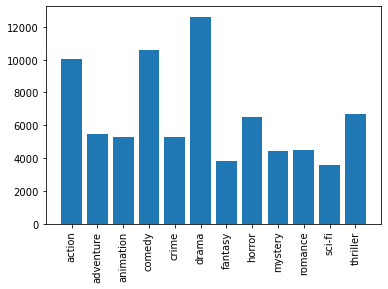

In [39]:
plt.bar(data.iloc[:,6:18].sum(axis=0).index,data.iloc[:,6:18].sum(axis=0).values)
plt.xticks(rotation='vertical')

Na stubićima se i dalje uočavaju razlike između žanrova, ali su one manje izražene nego pre. Svakako ne treba težiti da svi stubići budu jednaki jer ovakvi podaci predstavljaju realnu sliku (s obzirom da komedija, drama i akcija jesu najčešći žanrovi).
Cilj je bio samo smanjiti razlike kako bi naš model mogao da nauči što bolje svaki od žanrova.

Na grafiku ispod vidimo da smo malo poboljšali i odnos svih kombinacija žanrova.

In [40]:
kombinacije_zanrova=pd.get_dummies(data.genre)

In [41]:
kombinacije_zanrova.sum(axis=0)

action                       453
action, adventure            106
action, adventure, comedy    473
action, adventure, crime     235
action, adventure, drama     433
                            ... 
short, romance, thriller       1
short, sci-fi                207
short, sci-fi, thriller       22
short, thriller               17
thriller                     802
Length: 354, dtype: int64

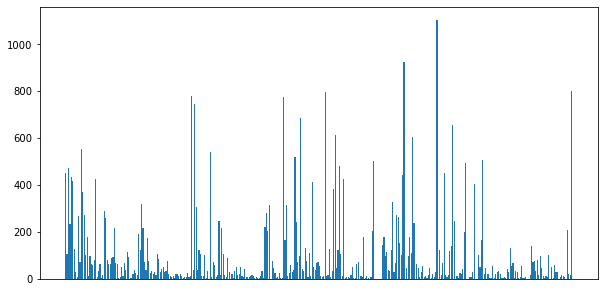

In [42]:
plt.figure(figsize=(10, 5))
plt.bar(kombinacije_zanrova.sum(axis=0).index,kombinacije_zanrova.sum(axis=0).values)
plt.xticks(ticks=[])
plt.show()

In [43]:
data

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,thriller,broj_zanrova
1,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,0,2
3,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,0,2
5,5,https://m.media-amazon.com/images/M/MV5BNDU3YT...,The Zone of Twilight,2020,9.9,"action, horror, sci-fi",1,0,0,0,0,0,0,1,0,0,1,0,3
6,6,https://m.media-amazon.com/images/M/MV5BZThmOW...,Hollywood,2020,9.8,"comedy, crime",0,0,0,1,1,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41970,42012,https://m.media-amazon.com/images/M/MV5BYzhlND...,Dragon Tiger Gate,2006,6.2,"action, drama, fantasy",1,0,0,0,0,1,1,0,0,0,0,0,3
41971,42013,https://m.media-amazon.com/images/M/MV5BMzY1MT...,All the King's Men,2006,6.2,"drama, thriller",0,0,0,0,0,1,0,0,0,0,0,1,2
41972,42014,https://m.media-amazon.com/images/M/MV5BMDg5NT...,Playing House,2006,6.2,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,2
41974,42016,https://m.media-amazon.com/images/M/MV5BMTgxNz...,Demon Empire,2006,6.2,"action, adventure, drama",1,1,0,0,0,1,0,0,0,0,0,0,3


In [44]:
#popravljamo indekse da idu od 0 do 35248

In [45]:
data['indeks'] = range(35248) #dodajemo novu kolonu koja predstavlja brojeve od 0 do 35248

In [46]:
data=data.set_index(['indeks']) #postavljamo je da bude u svojstvu indeksa

In [47]:
data

,id,poster,title,year,rating,genre,action,adventure,animation,comedy,crime,drama,fantasy,horror,mystery,romance,sci-fi,thriller,broj_zanrova
indeks,,,,,,,,,,,,,,,,,,,
0,1,https://m.media-amazon.com/images/M/MV5BNTgyZD...,RED,2020,10.0,horror,0,0,0,0,0,0,0,1,0,0,0,0,1
1,2,https://m.media-amazon.com/images/M/MV5BNGQzMT...,Huldra and Photographer,2020,10.0,"short, fantasy, horror",0,0,0,0,0,0,1,1,0,0,0,0,2
2,3,https://m.media-amazon.com/images/M/MV5BMWE2Yz...,Anti-dirt,2020,10.0,"short, action, comedy",1,0,0,1,0,0,0,0,0,0,0,0,2
3,5,https://m.media-amazon.com/images/M/MV5BNDU3YT...,The Zone of Twilight,2020,9.9,"action, horror, sci-fi",1,0,0,0,0,0,0,1,0,0,1,0,3
4,6,https://m.media-amazon.com/images/M/MV5BZThmOW...,Hollywood,2020,9.8,"comedy, crime",0,0,0,1,1,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35243,42012,https://m.media-amazon.com/images/M/MV5BYzhlND...,Dragon Tiger Gate,2006,6.2,"action, drama, fantasy",1,0,0,0,0,1,1,0,0,0,0,0,3
35244,42013,https://m.media-amazon.com/images/M/MV5BMzY1MT...,All the King's Men,2006,6.2,"drama, thriller",0,0,0,0,0,1,0,0,0,0,0,1,2
35245,42014,https://m.media-amazon.com/images/M/MV5BMDg5NT...,Playing House,2006,6.2,"comedy, romance",0,0,0,1,0,0,0,0,0,1,0,0,2


### Učitavanje postera

Svi posteri su zadati preko linkova koji se nalaze u bazi. Slike učitavamo u listu i obraćamo pažnju na one linkove koji vraćaju neku grešku. Te redove ćemo izbaciti iz naših podataka.

In [48]:
putanja_do_slika=data.poster

In [49]:
putanja_do_slika.shape

(35248,)

In [50]:
slike=[]
indeksi_neispravnih_linkova=[]
iterator=0

In [51]:
for i in putanja_do_slika:
    try:
        urllib.request.urlretrieve(i, "slika.png")
        img=PIL.Image.open("slika.png").convert("RGBA")
        slike.append(img)
        iterator=iterator+1
    except:
        indeksi_neispravnih_linkova.append(iterator)
        iterator=iterator+1

In [52]:
len(slike) #ukupno imamo 34957 postera

34957

In [53]:
len(indeksi_neispravnih_linkova)  #broj redova koje je potrebno da izbacimo iz podataka

291

In [54]:
data.drop(index=indeksi_neispravnih_linkova, inplace=True) #izbacujemo neispravne redove

In [55]:
data.shape 

(34957, 19)

Završili smo sa čišćenjem podataka i vidimo da sada naša baza ima 34957 instanci.

## Priprema podataka za model

Naša zavisna promeljiva predstavlja binarni vektor dužine 12. Svaka pozicija odgovara određenom žanru filma. Film je onih žanrova koji imaju jedinicu na svojim pozicijama.

Uz pomoć binarno kodiranih kolona koje se već nalaze u tabeli, definišemo našu zavisnu promenljivu y.

In [56]:
data.iloc[:,6:18].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [57]:
y=[]

In [58]:
for i in data.iloc[:,6:18].values:
    y.append(i)

In [60]:
imena_klasa=list(data.columns[6:18])

In [61]:
imena_klasa

['action',
 'adventure',
 'animation',
 'comedy',
 'crime',
 'drama',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'sci-fi',
 'thriller']

In [62]:
#funkcija koja vraća žanr filma na osnovu binarno kodiranog vektora
#ova funkcija nam služi za ilustraciju naših podataka za model
def zanr(niz):
    zanr=[]
    for i in range(len(niz)):
        if(niz[i]==1):
            zanr.append(imena_klasa[i])
        else:
            None
    return zanr        
            

U narednim linijama koda prikazano je kako izgledaju podaci za naš model, dve nasumične slike iz učitane liste slika, kao i vektor zavisne promenljive koji ide uz njih.

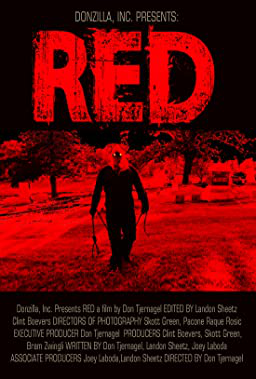

In [63]:
slike[0]

In [64]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

In [65]:
zanr(y[0]) #pozivamo funkciju koja ce nam procitati zanr

['horror']

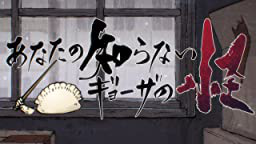

In [66]:
slike[465]

In [67]:
y[465]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [68]:
zanr(y[465])

['animation']

Menjamo veličinu slika kako bi sve slike bile istih dimenzija. Smanjujemo ih da bi mreža imala manje parametara i da bi bila
lakša za treniranje.

In [69]:
for brojac in range(len(slike)):
    slike[brojac]=slike[brojac].resize(size=(128,128))

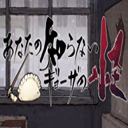

In [70]:
slike[465] #prikaz kako slika izgleda nakon promene veličine

In [71]:
slike[465].mode #proveravamo kako su slike zadate

'RGBA'

Slike imaju i alfa kanal koji ćemo ukloniti.

In [72]:
for brojac in range(len(slike)):
    slike[brojac]=slike[brojac].convert('RGB')

In [73]:
slike[465].mode

'RGB'

Delimo podatke na trening, validacioni i test skup u odnosu 70:15:15. Prilikom podele podataka pazimo da kombinacije žanrova budu ravnomerno raspodeljene i u trening i u test skupu i iz tog razloga podešavamo stratify=y i stratify=y_train_val.

In [74]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(slike,y, test_size=0.15,stratify=y)

In [75]:
X_train, X_validation, y_train, y_validation=model_selection.train_test_split(X_train_val,y_train_val, test_size=0.1765,stratify=y_train_val)

In [76]:
print(len(X_train),len(X_test),len(X_validation),len(y_train),len(y_test),len(y_validation)) #veličine skupova

24468 5244 5245 24468 5244 5245


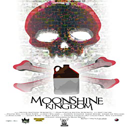

In [77]:
X_train[0]

In [78]:
y_train[0]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [79]:
zanr(y_train[0])

['action', 'comedy']

X_train i X_test su liste slika, a y_train i y_test su liste nizova. Prvo pretvaramo slike u nizove.

In [80]:
for brojac in range(len(X_test)):
    X_test[brojac]=np.asarray(X_test[brojac])


In [81]:
for brojac in range(len(X_train)):
    X_train[brojac]=np.asarray(X_train[brojac])

In [82]:
for brojac in range(len(X_validation)):
    X_validation[brojac]=np.asarray(X_validation[brojac])

Nakon toga, pošto sad imamo liste nizova, konvertujemo liste u nizove.

In [84]:
X_test=np.asarray(X_test)

In [85]:
X_train=np.asarray(X_train)

In [86]:
X_validation=np.asarray(X_validation)

In [87]:
#normalizacija slika i promena iz uint8 u float32. Slike smo skalirali na interval [-1,1] jer je ugrađena ResNet50 mreža, 
#koju ćemo koristiti, trenirana na tako skaliranim slikama.

In [88]:
X_test = X_test.astype('float32')
X_test /= 127.5
X_test= X_test-1

In [89]:
X_train = X_train.astype('float32')
X_train /= 127.5
X_train= X_train-1

In [90]:
X_validation = X_validation.astype('float32')
X_validation /= 127.5
X_validation= X_validation-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


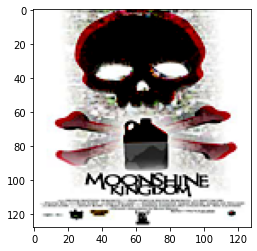

In [91]:
plt.imshow(X_train[0]) #slike sada možemo videti korišćenjem paketa matplotlib

In [92]:
X_test.shape

(5244, 128, 128, 3)

In [93]:
X_train.shape #vidimo da ćemo za trening mreže imati 24468 slika dimenzije (128,128,3)

(24468, 128, 128, 3)

In [94]:
X_validation.shape

(5245, 128, 128, 3)

In [95]:
y_train=np.asarray(y_train) #prebacujemo i y_train,y_validation i y_test u niz nizova
y_test=np.asarray(y_test)
y_validation=np.asarray(y_validation)

In [96]:
y_train.shape

(24468, 12)

In [97]:
y_test.shape

(5244, 12)

In [98]:
y_validation.shape

(5245, 12)

### Pravljenje modela

#### Model 1

In [99]:
velicina_ulaza=(128,128,3)

In [100]:
broj_klasa=12

In [101]:
model_resnet50_v2= Sequential()

Koristimo prethodno istrenirani ResNet50 model. Sve konvolutivne neuronske mreže u početnim slojevima uče osnovne/slične paterne, iz tog razloga koristešćenje već istreniranih modela pravi veliku uštedu vremena. Takođe, ovi modeli su trenirani na ogromnoj količini podataka koju bi bilo teško obezbediti ako bismo sami trenirali ceo model. Praksa kod već istreniranih modela je da njihove težine iz konvolutivnog dela mreže sačuvamo, a da težine iz potpuno povezanog dela sami treniramo.

U potpuno povezanom sloju koristimo gusti sloj od 512 neurona, dropout sloj koji sprečava regularizaciju i izlazni sloj sa 12 neurona, jer imamo 12 klasa. U poslednjem sloju koristimo sigmoidnu aktivacionu funkciju kako bismo dobili verovatnoće pripadanja svakoj od klasa.

In [102]:
pretrained_model_v2=ResNet50(weights='imagenet',include_top=False,input_shape=velicina_ulaza, classes= broj_klasa)
for layer in pretrained_model_v2.layers:
    layer.trainable=False #fiksiramo slojeve mreže koje ne želimo da treniramo

In [103]:
model_resnet50_v2.add(pretrained_model_v2)

In [104]:
model_resnet50_v2.add(Flatten())

In [105]:
model_resnet50_v2.add(Dense(512, activation='relu'))
model_resnet50_v2.add(Dropout(0.5))
model_resnet50_v2.add(Dense(12, activation='sigmoid'))

In [106]:
model_resnet50_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
Total params: 40,371,596
Trainable params: 16,783,884
Non-trainable params: 23,587,712
_________________________________________________________________


Od ukupnih 40371596 parametara, naša mreža treba da nauči 16783884.

Koristimo Adam optimizator i binarnu unakrsnu entropiju kao funkciju greške. Veličina paketića je 32, broj epoha 30, a lr 0.001.

In [107]:
batch_size = 128
epochs = 30

In [108]:
model_resnet50_v2.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50_v2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

Epoch 1/30
192/192 [==============================] - 445s 2s/step - loss: 0.4679 - accuracy: 0.2173 - val_loss: 0.4352 - val_accuracy: 0.2431
Epoch 2/30
192/192 [==============================] - 434s 2s/step - loss: 0.4435 - accuracy: 0.2558 - val_loss: 0.4323 - val_accuracy: 0.2429
Epoch 3/30
192/192 [==============================] - 434s 2s/step - loss: 0.4375 - accuracy: 0.2622 - val_loss: 0.4301 - val_accuracy: 0.3058
Epoch 4/30
192/192 [==============================] - 434s 2s/step - loss: 0.4326 - accuracy: 0.2744 - val_loss: 0.4302 - val_accuracy: 0.2936
Epoch 5/30
192/192 [==============================] - 434s 2s/step - loss: 0.4301 - accuracy: 0.2802 - val_loss: 0.4309 - val_accuracy: 0.2770
Epoch 6/30
192/192 [==============================] - 434s 2s/step - loss: 0.4251 - accuracy: 0.2879 - val_loss: 0.4327 - val_accuracy: 0.2555
Epoch 7/30
192/192 [==============================] - 436s 2s/step - loss: 0.4218 - accuracy: 0.2897 - val_loss: 0.4319 - val_accuracy: 0.2864

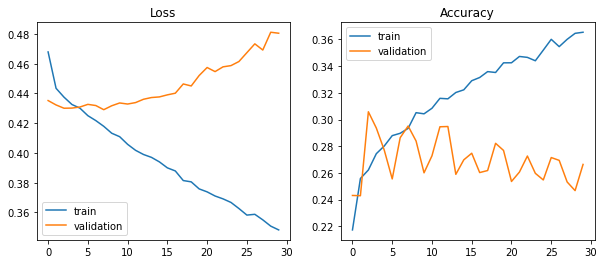

In [109]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Iz grafika već možemo primetiti da ovaj model nije zadovoljavajuć, greška na trening skupu se smanjuje, tačnost raste, ali se obrnuto događa na skupu za validaciju, što nam pokazuje da se model previše prilagođava datim podacima. Svakako, proverićemo i koje rezultate daju osnovne tehnike evaluacije.

##### Evaluacija modela

In [110]:
y_predikcija=model_resnet50_v2.predict(X_test)

164/164 [==============================] - 100s 603ms/step


Pošto smo koristili sigmoidnu funkciju, vrednost y_predikcija će biti vektor dužine 13 koji ima brojeve između 0 i 1.
Oni predstavljaju verovatnoću pripadanja odredjenoj klasi. Kako bismo dobili konačne vrednosti predikcije potrebno je da
brojeve koji su manji od 0.5 zamenimo sa 0, a oni koji su veći ili jednaki zamenimo sa 1.

In [111]:
y_pred=[]

In [112]:
for i in y_predikcija:
  y_pred.append([1 if j>=0.5 else 0 for j in i ])
# sa i se krecemo kroz y_predikcija, odnosno i predstavlja vektor dužine 13, a sa j se krećemo kroz tih 13 brojeva i
# zamenjujemo ih jedinicom ili nulom u zavisnosti od toga da li su veci(i jednaki) od 0.5 ili manji.

In [113]:
y_pred = np.array(y_pred)
y_pred

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

U problemu višeklasne klasifikacije kod kog zavisna promenljiva može imati više klasa postoje različite tehnike evaluacije koje se mogu razlikovati od tehnika evaluacije za binarnu klasifikaciju. Prilikom poziva funkcije multilabel_confusion_matrix dobijamo više matrica konfuzije. Svaka matrica odgovara jednoj klasi i treba obratiti pažnju na to da je raspored elemenata u matrici drugačiji od standardne matrice konfuzije. U prvom redu nalaze se brojevi TN i FP, redom, a u drugom redu FN i TP. 


TN- broj koliko puta model nije predvideo određenu klasu i ta klasa nije ni trebalo da bude pogođena
FP- broj koliko je puta model predvideo određenu klasu, a ona nije bila tačna
FN- broj koliko puta model nije predvideo određenu klasu, a ona je bila tačna
TP- broj koliko je puta model predvideo određenu klasu i ona je bila tačna

In [114]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[3465,  289],
        [1185,  305]],

       [[4376,   55],
        [ 777,   36]],

       [[4330,  124],
        [ 532,  258]],

       [[3105,  556],
        [1016,  567]],

       [[4379,   73],
        [ 756,   36]],

       [[2877,  490],
        [1446,  431]],

       [[4677,    1],
        [ 566,    0]],

       [[4127,  153],
        [ 839,  125]],

       [[4576,    6],
        [ 660,    2]],

       [[4536,   39],
        [ 631,   38]],

       [[4707,    4],
        [ 528,    5]],

       [[4190,   58],
        [ 973,   23]]], dtype=int64)

I iz matrica konfuzije vidimo da naš model nije mnogo dobar. Model za sve klase uglavnom predviđa da se film ne nalazi u datoj klasi i iz tog razloga imamo veliki broj TN i FN vrednosti. Takodje klase kao što su naučna fantastika, misterija i horor skoro da i ne smatra mogućim, pa je retko kojoj instanci pridodao pripadnost ovim klasama. Razlog za ovako loše učenje ovih klasa je verovatno njihova manja zastupljenost među podacima. Možemo primetiti da najviše TP i FP vrednosti imaju zastupljenije klase iz čega zaključujemo da model nije dobro naučio da generalizuje, pa uglavnom predvidja većinske klase.

Preciznost i odziv za svaku klasu računaju se na isti način kao i inače. F1-score je harmonijska sredina preciznosti i odziva.

Precision = TP/(TP + FP) 

Recall = TP/(TP + FN) 

Macro avg od neke mere predstavlja prosek vrednosti te mere za sve klase. Micro avg računa preciznost, odziv i f1-score po poznatim formulama, ali umesto TP,TN,FP i FN za jednu klasu koristi ove vrednosti sabrane za sve klase. Samples avg računa svaku od mera evaluacije za sve instance redom i uprosečava ih.

In [115]:
print(classification_report(y_test, y_pred,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.51      0.20      0.29      1490
   adventure       0.40      0.04      0.08       813
   animation       0.68      0.33      0.44       790
      comedy       0.50      0.36      0.42      1583
       crime       0.33      0.05      0.08       792
       drama       0.47      0.23      0.31      1877
     fantasy       0.00      0.00      0.00       566
      horror       0.45      0.13      0.20       964
     mystery       0.25      0.00      0.01       662
     romance       0.49      0.06      0.10       669
      sci-fi       0.56      0.01      0.02       533
    thriller       0.28      0.02      0.04       996

   micro avg       0.50      0.16      0.24     11735
   macro avg       0.41      0.12      0.17     11735
weighted avg       0.43      0.16      0.21     11735
 samples avg       0.27      0.16      0.19     11735



In [283]:
macro_f1_1=0.17

Accuracy_score predstavlja odnos broja tačno pogođenih predikcija i svih predikcija. 

In [178]:
acc1=accuracy_score(y_test,y_pred)
acc1

0.02917620137299771

Ovo je najstroža mera jer zahteva da bude pogođen svaki navedeni žanr filma. Kod modela koji mogu imati više tačnih klasa ne možemo isto tretirati predikciju koja nema pogođenu nijednu tačnu klasu i onu kod koje je bar nešto tačno, iz tog razloga koristi se blaža tehnika evaluacije koja se zove hamming_loss. Ona predstavlja odnos broja pogrešno predviđenih klasa u svim iteracijama i broja svih predviđanja ukupno. Model treba da ima što manji hamming_loss.

In [177]:
hamming1=hamming_loss(y_test, y_pred)
hamming1

0.18683257055682684

In [330]:
model_resnet50_v2.save('model_resnet50_v2.h5')


#### Model 2

Pokušaćemo da popravimo rezultate prethodnog modela. Ovaj model se neće mnogo razlikovati od prethodnog, već ćemo samo povećanjem parametra u dropout sloju pokušati da smanjimo preprilagođavanje.

In [121]:
model_resnet50_v2_= Sequential()

In [122]:
model_resnet50_v2_.add(pretrained_model_v2)
model_resnet50_v2_.add(Flatten())
model_resnet50_v2_.add(Dense(512, activation='relu'))
model_resnet50_v2_.add(Dropout(0.7))
model_resnet50_v2_.add(Dense(12, activation='sigmoid'))

In [123]:
batch_size = 128
epochs = 20

In [124]:
model_resnet50_v2_.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50_v2_.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

Epoch 1/20
192/192 [==============================] - 433s 2s/step - loss: 0.4872 - accuracy: 0.1956 - val_loss: 0.4380 - val_accuracy: 0.2463
Epoch 2/20
192/192 [==============================] - 425s 2s/step - loss: 0.4603 - accuracy: 0.2299 - val_loss: 0.4395 - val_accuracy: 0.2498
Epoch 3/20
192/192 [==============================] - 425s 2s/step - loss: 0.4561 - accuracy: 0.2380 - val_loss: 0.4373 - val_accuracy: 0.2896
Epoch 4/20
192/192 [==============================] - 425s 2s/step - loss: 0.4505 - accuracy: 0.2417 - val_loss: 0.4346 - val_accuracy: 0.2805
Epoch 5/20
192/192 [==============================] - 424s 2s/step - loss: 0.4480 - accuracy: 0.2468 - val_loss: 0.4322 - val_accuracy: 0.2829
Epoch 6/20
192/192 [==============================] - 425s 2s/step - loss: 0.4451 - accuracy: 0.2539 - val_loss: 0.4313 - val_accuracy: 0.2559
Epoch 7/20
192/192 [==============================] - 425s 2s/step - loss: 0.4421 - accuracy: 0.2595 - val_loss: 0.4330 - val_accuracy: 0.2503

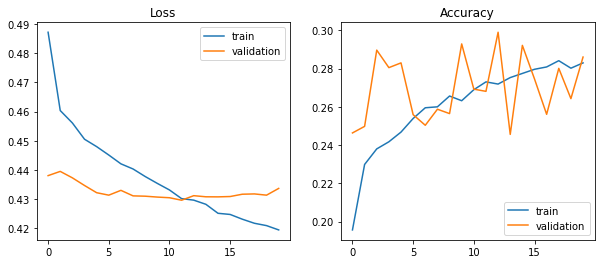

In [125]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Sa grafika vidimo da preprilagođavanje počinje od kasnije epohe, ali suštinski ovaj model nije doneo neka poboljšanja.

##### Evaluacija modela

In [221]:
y_predikcija_v2_=model_resnet50_v2_.predict(X_test)
y_pred_v2_=[]
for i in y_predikcija_v2_:
  y_pred_v2_.append([1 if j>=0.5 else 0 for j in i ])
y_pred_v2_ = np.array(y_pred_v2_)

164/164 [==============================] - 108s 536ms/step


In [222]:
multilabel_confusion_matrix(y_test, y_pred_v2_)

array([[[3665,   89],
        [1354,  136]],

       [[4428,    3],
        [ 812,    1]],

       [[4414,   40],
        [ 656,  134]],

       [[3448,  213],
        [1264,  319]],

       [[4452,    0],
        [ 792,    0]],

       [[3329,   38],
        [1849,   28]],

       [[4678,    0],
        [ 566,    0]],

       [[4273,    7],
        [ 963,    1]],

       [[4582,    0],
        [ 662,    0]],

       [[4568,    7],
        [ 657,   12]],

       [[4711,    0],
        [ 533,    0]],

       [[4244,    4],
        [ 993,    3]]], dtype=int64)

Iz matrica konfuzija i dole prikazanog klasifikacionog izveštaja vidimo da je ovaj model još lošije uči od prethodnog. Iz preciznosti i odziva vidimo da model skoro da i ne predvidja neku klasu pozitivnom, a kad to i uradi verovatnoća da je pogodio nije velika.

In [223]:
print(classification_report(y_test, y_pred_v2_,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.60      0.09      0.16      1490
   adventure       0.25      0.00      0.00       813
   animation       0.77      0.17      0.28       790
      comedy       0.60      0.20      0.30      1583
       crime       0.00      0.00      0.00       792
       drama       0.42      0.01      0.03      1877
     fantasy       0.00      0.00      0.00       566
      horror       0.12      0.00      0.00       964
     mystery       0.00      0.00      0.00       662
     romance       0.63      0.02      0.03       669
      sci-fi       0.00      0.00      0.00       533
    thriller       0.43      0.00      0.01       996

   micro avg       0.61      0.05      0.10     11735
   macro avg       0.32      0.04      0.07     11735
weighted avg       0.38      0.05      0.09     11735
 samples avg       0.10      0.05      0.07     11735



In [232]:
macro_f1_2=0.07

In [224]:
acc2=accuracy_score(y_test,y_pred_v2_)
acc2

0.008581235697940504

In [225]:
hamming2=hamming_loss(y_test,y_pred_v2_)
hamming2

0.18278032036613273

In [331]:
model_resnet50_v2_.save('model_resnet50_v2_.h5')

#### Model 3

Ovim modelom pokušaćemo da dođemo do boljih rezultata tako što ćemo trenirati i neke od težina ugrađene ResNet50 mreže kako bismo je više prilagodili našem zadatku. ResNet50 mreže sadrže u sebi blokove koji izgledaju kao na slici ispod. Parametre poslednjeg bloka ćemo podesiti da budu mogući za trening. Zbog loših rezultata prethodnog sloja, dropout parametar ćemo smanjiti na 0.6. Ostale vrednosti ostaju iste kao za prethodni model.

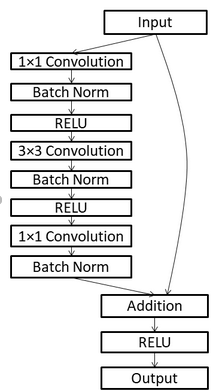

In [288]:
pretrained_model_v2_1=ResNet50(weights='imagenet',include_top=False,input_shape=velicina_ulaza, classes= broj_klasa)
for i in pretrained_model_v2_1.layers[165:176]:
    print(i)


In [289]:
model_resnet50_v2_1= Sequential()
pretrained_model_v2_1=ResNet50(weights='imagenet',include_top=False,input_shape=velicina_ulaza, classes= broj_klasa)
for i in range(len(pretrained_model_v2_1.layers)-10):
    pretrained_model_v2_1.layers[i].trainable = False
model_resnet50_v2_1.add(pretrained_model_v2_1)
model_resnet50_v2_1.add(Flatten())
model_resnet50_v2_1.add(Dense(512, activation='relu'))
model_resnet50_v2_1.add(Dropout(0.6))
model_resnet50_v2_1.add(Dense(12, activation='sigmoid'))
model_resnet50_v2_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 12)                6156      
                                                                 
Total params: 40,371,596
Trainable params: 21,249,548
Non-trainable params: 19,122,048
_________________________________________________________________


In [290]:
batch_size = 128
epochs = 20
model_resnet50_v2_1.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50_v2_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

Epoch 1/20
192/192 [==============================] - 571s 3s/step - loss: 0.4903 - accuracy: 0.2085 - val_loss: 0.4355 - val_accuracy: 0.2446
Epoch 2/20
192/192 [==============================] - 556s 3s/step - loss: 0.4488 - accuracy: 0.2453 - val_loss: 0.4333 - val_accuracy: 0.2378
Epoch 3/20
192/192 [==============================] - 561s 3s/step - loss: 0.4414 - accuracy: 0.2641 - val_loss: 0.4343 - val_accuracy: 0.2597
Epoch 4/20
192/192 [==============================] - 562s 3s/step - loss: 0.4354 - accuracy: 0.2750 - val_loss: 0.4301 - val_accuracy: 0.2566
Epoch 5/20
192/192 [==============================] - 559s 3s/step - loss: 0.4288 - accuracy: 0.2875 - val_loss: 0.4291 - val_accuracy: 0.2700
Epoch 6/20
192/192 [==============================] - 566s 3s/step - loss: 0.4219 - accuracy: 0.2926 - val_loss: 0.4562 - val_accuracy: 0.2711
Epoch 7/20
192/192 [==============================] - 561s 3s/step - loss: 0.4140 - accuracy: 0.3109 - val_loss: 0.4411 - val_accuracy: 0.2427

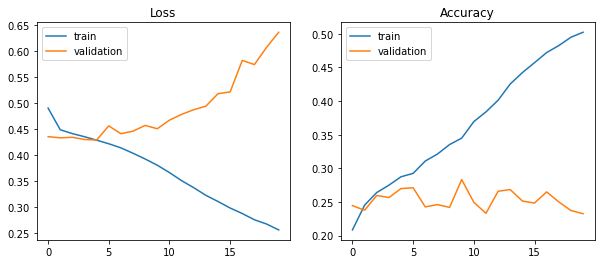

In [293]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

Preprilagođavanje je i dalje prisutno, ali u poređenju s prošlim modelom, model ima manju grešku na trening skupu nakon 20 epoha. 

##### Evaluacija modela

In [294]:
y_predikcija_v2_1=model_resnet50_v2_1.predict(X_test)
y_pred_v2_1=[]
for i in y_predikcija_v2_1:
  y_pred_v2_1.append([1 if j>=0.5 else 0 for j in i ])
y_pred_v2_1 = np.array(y_pred_v2_1)

164/164 [==============================] - 95s 570ms/step


In [295]:
multilabel_confusion_matrix(y_test, y_pred_v2_1)

array([[[3496,  258],
        [1229,  261]],

       [[4370,   61],
        [ 774,   39]],

       [[4044,  410],
        [ 375,  415]],

       [[3004,  657],
        [ 965,  618]],

       [[4317,  135],
        [ 724,   68]],

       [[2630,  737],
        [1270,  607]],

       [[4678,    0],
        [ 566,    0]],

       [[3887,  393],
        [ 724,  240]],

       [[4530,   52],
        [ 639,   23]],

       [[4387,  188],
        [ 568,  101]],

       [[4710,    1],
        [ 533,    0]],

       [[4050,  198],
        [ 888,  108]]], dtype=int64)

In [296]:
print(classification_report(y_test, y_pred_v2_1,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.50      0.18      0.26      1490
   adventure       0.39      0.05      0.09       813
   animation       0.50      0.53      0.51       790
      comedy       0.48      0.39      0.43      1583
       crime       0.33      0.09      0.14       792
       drama       0.45      0.32      0.38      1877
     fantasy       0.00      0.00      0.00       566
      horror       0.38      0.25      0.30       964
     mystery       0.31      0.03      0.06       662
     romance       0.35      0.15      0.21       669
      sci-fi       0.00      0.00      0.00       533
    thriller       0.35      0.11      0.17       996

   micro avg       0.45      0.21      0.29     11735
   macro avg       0.34      0.17      0.21     11735
weighted avg       0.38      0.21      0.26     11735
 samples avg       0.34      0.22      0.25     11735



In [311]:
macro_f1_3=0.21

In [297]:
acc3=accuracy_score(y_test,y_pred_v2_1)
acc3

0.041952707856598014

In [298]:
hamming3=hamming_loss(y_test,y_pred_v2_1)
hamming3

0.19617658276125097

In [332]:
model_resnet50_v2_1.save('model_resnet50_v2_1.h5')

#### Model 4

Ovaj model se od prethodnog razlikuje u vrednosti parametra learning rate. Ovu vrednost smo smanjili na 0.0005 kako bismo ispitali da li ona ima neki pozitivni uticaj na rezultate modela.

In [299]:
model_resnet50_v2_2= Sequential()
model_resnet50_v2_2.add(pretrained_model_v2_1)
model_resnet50_v2_2.add(Flatten())
model_resnet50_v2_2.add(Dense(512, activation='relu'))
model_resnet50_v2_2.add(Dropout(0.6))
model_resnet50_v2_2.add(Dense(12, activation='sigmoid'))
model_resnet50_v2_2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 12)                6156      
                                                                 
Total params: 40,371,596
Trainable params: 21,249,548
Non-trainable params: 19,122,048
_________________________________________________________________


In [300]:
batch_size = 128
epochs = 20
model_resnet50_v2_2.compile(optimizer=Adam(lr=0.0005),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50_v2_2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

Epoch 1/20
192/192 [==============================] - 562s 3s/step - loss: 0.3051 - accuracy: 0.4415 - val_loss: 0.5227 - val_accuracy: 0.2740
Epoch 2/20
192/192 [==============================] - 556s 3s/step - loss: 0.2049 - accuracy: 0.5288 - val_loss: 0.5979 - val_accuracy: 0.2631
Epoch 3/20
192/192 [==============================] - 556s 3s/step - loss: 0.1605 - accuracy: 0.5493 - val_loss: 0.6995 - val_accuracy: 0.2372
Epoch 4/20
192/192 [==============================] - 557s 3s/step - loss: 0.1291 - accuracy: 0.5512 - val_loss: 0.7794 - val_accuracy: 0.2425
Epoch 5/20
192/192 [==============================] - 563s 3s/step - loss: 0.1046 - accuracy: 0.5499 - val_loss: 0.8602 - val_accuracy: 0.2309
Epoch 6/20
192/192 [==============================] - 556s 3s/step - loss: 0.0850 - accuracy: 0.5498 - val_loss: 0.9123 - val_accuracy: 0.2214
Epoch 7/20
192/192 [==============================] - 564s 3s/step - loss: 0.0715 - accuracy: 0.5512 - val_loss: 1.0048 - val_accuracy: 0.2231

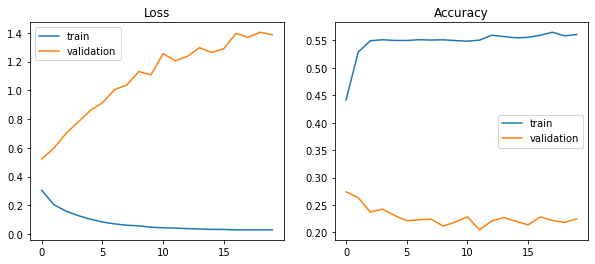

In [301]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

##### Evaluacija modela

In [302]:
y_predikcija_v2_2=model_resnet50_v2_2.predict(X_test)

164/164 [==============================] - 90s 544ms/step


In [303]:
y_pred_v2_2=[]

In [304]:
for i in y_predikcija_v2_2:
  y_pred_v2_2.append([1 if j>=0.5 else 0 for j in i ])

In [305]:
y_pred_v2_2 = np.array(y_pred_v2_2)

In [306]:
multilabel_confusion_matrix(y_test, y_pred_v2_2)

array([[[3070,  684],
        [ 953,  537]],

       [[4148,  283],
        [ 691,  122]],

       [[4151,  303],
        [ 433,  357]],

       [[2843,  818],
        [ 854,  729]],

       [[4010,  442],
        [ 644,  148]],

       [[2234, 1133],
        [1028,  849]],

       [[4466,  212],
        [ 531,   35]],

       [[3830,  450],
        [ 725,  239]],

       [[4323,  259],
        [ 594,   68]],

       [[4397,  178],
        [ 570,   99]],

       [[4486,  225],
        [ 480,   53]],

       [[3727,  521],
        [ 781,  215]]], dtype=int64)

U odnosu na prethodne modele primećujemo povećanje broja TP i FP vrednosti. I dalje te vrednosti nisu velike i model ne obavlja dobro zadatak za koji ga ubučavamo.

In [307]:
print(classification_report(y_test, y_pred_v2_2,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.44      0.36      0.40      1490
   adventure       0.30      0.15      0.20       813
   animation       0.54      0.45      0.49       790
      comedy       0.47      0.46      0.47      1583
       crime       0.25      0.19      0.21       792
       drama       0.43      0.45      0.44      1877
     fantasy       0.14      0.06      0.09       566
      horror       0.35      0.25      0.29       964
     mystery       0.21      0.10      0.14       662
     romance       0.36      0.15      0.21       669
      sci-fi       0.19      0.10      0.13       533
    thriller       0.29      0.22      0.25       996

   micro avg       0.39      0.29      0.33     11735
   macro avg       0.33      0.24      0.28     11735
weighted avg       0.36      0.29      0.32     11735
 samples avg       0.36      0.30      0.30     11735



In [310]:
macro_f1_4=0.28

In [308]:
acc4=accuracy_score(y_test,y_pred_v2_2)
acc4

0.03985507246376811

In [309]:
hamming4=hamming_loss(y_test, y_pred_v2_2)
hamming4

0.21917111619628782

In [333]:
model_resnet50_v2_2.save('model_resnet50_v2_2.h5')

#### Model 5

Ispitaćemo još rad modela kod kog ćemo istrenirati sve slojeve ugrađenje ResNet mreže. Ostali parametri ostaju podešeni isto kao i u prethodnom modelu.

In [190]:
model_resnet50_v2_3= Sequential()
pretrained_model_v2_3=ResNet50(weights='imagenet',include_top=False,input_shape=velicina_ulaza, classes= broj_klasa)
for i in range(len(pretrained_model_v2_3.layers)):
    pretrained_model_v2_3.layers[i].trainable = True
model_resnet50_v2_3.add(pretrained_model_v2_3)
model_resnet50_v2_3.add(Flatten())
model_resnet50_v2_3.add(Dense(512, activation='relu'))
model_resnet50_v2_3.add(Dropout(0.6))
model_resnet50_v2_3.add(Dense(12, activation='sigmoid'))
model_resnet50_v2_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 12)                6156      
                                                                 
Total params: 40,371,596
Trainable params: 40,318,476
Non-trainable params: 53,120
_________________________________________________________________


In [191]:
batch_size = 128
epochs = 20
model_resnet50_v2_3.compile(optimizer=Adam(lr=0.0005),loss='binary_crossentropy',metrics=['accuracy'])
history = model_resnet50_v2_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validation,y_validation) )

Epoch 1/20
192/192 [==============================] - 1797s 9s/step - loss: 0.4951 - accuracy: 0.2609 - val_loss: 0.5787 - val_accuracy: 0.1497
Epoch 2/20
192/192 [==============================] - 1773s 9s/step - loss: 0.4137 - accuracy: 0.3244 - val_loss: 0.4926 - val_accuracy: 0.1195
Epoch 3/20
192/192 [==============================] - 1774s 9s/step - loss: 0.3967 - accuracy: 0.3503 - val_loss: 0.4581 - val_accuracy: 0.1727
Epoch 4/20
192/192 [==============================] - 1769s 9s/step - loss: 0.3735 - accuracy: 0.3741 - val_loss: 0.4374 - val_accuracy: 0.2540
Epoch 5/20
192/192 [==============================] - 1774s 9s/step - loss: 0.3550 - accuracy: 0.3893 - val_loss: 0.6542 - val_accuracy: 0.1500
Epoch 6/20
192/192 [==============================] - 1770s 9s/step - loss: 0.3547 - accuracy: 0.3907 - val_loss: 0.4340 - val_accuracy: 0.2915
Epoch 7/20
192/192 [==============================] - 1771s 9s/step - loss: 0.3421 - accuracy: 0.4016 - val_loss: 0.4364 - val_accuracy:

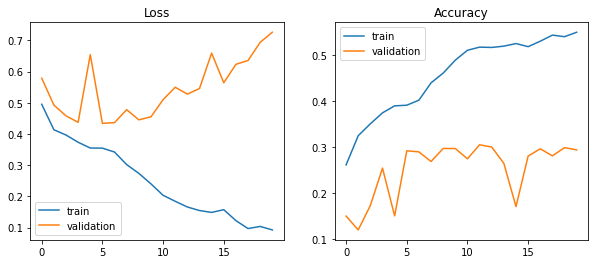

In [192]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

##### Evaluacija modela

In [197]:
y_predikcija_v2_3=model_resnet50_v2_3.predict(X_test)

164/164 [==============================] - 94s 565ms/step


In [210]:
y_pred_v2_3=[]

In [211]:
for i in y_predikcija_v2_3:
  y_pred_v2_3.append([1 if j>=0.5 else 0 for j in i ])

In [212]:
multilabel_confusion_matrix(y_test, y_pred_v2_3)

array([[[3094,  660],
        [ 851,  639]],

       [[4281,  150],
        [ 682,  131]],

       [[4152,  302],
        [ 239,  551]],

       [[2766,  895],
        [ 711,  872]],

       [[4189,  263],
        [ 682,  110]],

       [[2748,  619],
        [1276,  601]],

       [[4605,   73],
        [ 550,   16]],

       [[4117,  163],
        [ 796,  168]],

       [[4507,   75],
        [ 636,   26]],

       [[4464,  111],
        [ 554,  115]],

       [[4612,   99],
        [ 475,   58]],

       [[4079,  169],
        [ 885,  111]]], dtype=int64)

In [213]:
print(classification_report(y_test, y_pred_v2_3,target_names=imena_klasa))

              precision    recall  f1-score   support

      action       0.49      0.43      0.46      1490
   adventure       0.47      0.16      0.24       813
   animation       0.65      0.70      0.67       790
      comedy       0.49      0.55      0.52      1583
       crime       0.29      0.14      0.19       792
       drama       0.49      0.32      0.39      1877
     fantasy       0.18      0.03      0.05       566
      horror       0.51      0.17      0.26       964
     mystery       0.26      0.04      0.07       662
     romance       0.51      0.17      0.26       669
      sci-fi       0.37      0.11      0.17       533
    thriller       0.40      0.11      0.17       996

   micro avg       0.49      0.29      0.36     11735
   macro avg       0.43      0.24      0.29     11735
weighted avg       0.45      0.29      0.33     11735
 samples avg       0.41      0.30      0.32     11735



In [235]:
macro_f1_5=0.29

In [216]:
acc5=accuracy_score(y_test,y_pred_v2_3)
acc5

0.05682684973302822

In [217]:
hamming5=hamming_loss(y_test,y_pred_v2_3)
hamming5

0.18935926773455378

In [334]:
model_resnet50_v2_3.save('model_resnet50_v2_3.h5')

### Prikaz rezultata i poređenje modela

Posmatraćemo naših pet modela i njihove vrednosti za accuracy score, hamming loss i macro f1 score. F1 score gledamo jer obuhvata i preciznost i odziv pa time daje dobar uvid u to koliko je model dobar.

In [324]:
podaci_za_tabelu=[['Acc',0.0292, 0.0086, 0.0420, 0.0399, 0.0568],
                 ['Hamming loss',0.1868, 0.1828, 0.1962, 0.2192, 0.1894],
                 ['Macro F1 score',0.17,0.07,0.21,0.28,0.29]]

In [325]:
kolone=['Model 1','Model 2','Model 3','Model 4','Model 5']

In [326]:
print(tabulate(podaci_za_tabelu, headers=kolone, tablefmt="fancy_grid"))

╒════════════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╕
│                │   Model 1 │   Model 2 │   Model 3 │   Model 4 │   Model 5 │
╞════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Acc            │    0.0292 │    0.0086 │    0.042  │    0.0399 │    0.0568 │
├────────────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Hamming loss   │    0.1868 │    0.1828 │    0.1962 │    0.2192 │    0.1894 │
├────────────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ Macro F1 score │    0.17   │    0.07   │    0.21   │    0.28   │    0.29   │
╘════════════════╧═══════════╧═══════════╧═══════════╧═══════════╧═══════════╛


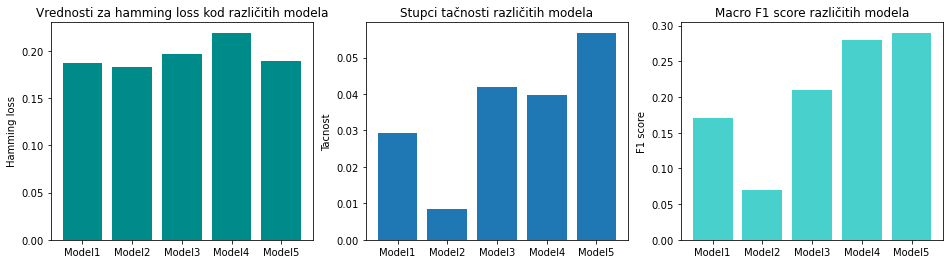

In [327]:
plt.figure(figsize=(16, 4)) 

plt.subplot(1, 3, 1)
plt.title('Vrednosti za hamming loss kod različitih modela')
plt.bar(['Model1','Model2','Model3','Model4','Model5'],np.array([hamming1,hamming2,hamming3,hamming4,hamming5]),color='darkcyan')
plt.ylabel('Hamming loss')

plt.subplot(1, 3, 2)
plt.title('Stupci tačnosti različitih modela')
plt.bar(['Model1','Model2','Model3','Model4','Model5'],np.array([acc1,acc2,acc3,acc4,acc5]))
plt.ylabel('Tacnost')

plt.subplot(1, 3, 3)
plt.bar(['Model1','Model2','Model3','Model4','Model5'],np.array([macro_f1_1,macro_f1_2,macro_f1_3,macro_f1_4,macro_f1_5]),color='mediumturquoise')
plt.title('Macro F1 score različitih modela')
plt.ylabel('F1 score')

plt.show()

Uz prikazane grafike iznad možemo lakše posmatrati rezultate i izneti neke zaključke.

Radi lakšeg pregleda podsetimo se arhitekture svakog od modela.
<br> Model1- korišćene težine već trenirane ResNet50 mreže, gusti sloj od 512 čvorova, dropout(0.5), gusti sloj sa 12 čvorova i lr 0.001
<br> Model2- korišćene težine već trenirane ResNet50 mreže, gusti sloj od 512 čvorova, dropout(0.7), gusti sloj sa 12 čvorova i lr 0.001
<br> Model3- trenirani parametri poslednjeg bloka ResNet50 mreže, gusti sloj od 512 čvorova, dropout(0.6), gusti sloj sa 12 čvorova i lr 0.001
<br> Model4- trenirani parametri poslednjeg bloka ResNet50 mreže, gusti sloj od 512 čvorova, dropout(0.6), gusti sloj sa 12 čvorova i lr 0.0005
<br> Model5- trenirane sve težine ResNet50 mreže, gusti sloj od 512 čvorova, dropout(0.6), gusti sloj sa 12 čvorova i lr 0.0005

Vrednost hamming loss je slična za sve modele, međutim najniža je za Model2. Razlog tome je što model2 skoro da ne daje nikakvo predviđanje. Pošto imamo veliki broj instanci i veliki broj klasa ako model svuda predviđa nule grešiće samo na mestima gde bi trebalo da su jedinice. Iz tog razloga se ne možemo osloniti samo na jednu meru evaluacija. Iako je model2 najbolji gledajuci hamming loss, posmatrajući širu sliku, odnosno tačnost i f1 score, zaključujemo zapravo da je model2 najgori. S obzirom da se on od modela1 razlikuje samo u povećanju dropout parametra vidimo da je ovo povećanje negativno uticalo na performanse modela. Razlog lošijeg ponašanja je verovatno to što je gašenjem određenih čvorova ispred sloja pomoću kog donosimo odluke prouzrokovalo manjak informacija što je otežalo modelu da donese odluku.

Što se tiče ostalih modela, ne može se reći da je ijedan dobar. Najbolje se pokazao model5 jer ima niži hamming loss, a više vrednosti za accuracy score i macro f1 score od ostalih. Ipak, ovaj model takođe ima izraženo preprilagođavanje i nije najbolji izbor za rešavanje ovog zadatka. Razlog zbog kog nijedan od ovih modela nije dobar je verovatno prevelika dubina mreža za ovu količinu podataka. Bolji izbor za rešavanje ovog problema bi verovatno bila ResNet18 ili ResNet34 mreža, međutim kako keras.application nema mogućnost korišćenja ovih mreža one nisu obrađene u ovom radu.